# MPNN Assignment
Learn a few things about alterning the outputs of neural networks

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras import layers, callbacks
import tensorflow as tf
from mpnn.layers import MessagePassingLayer, Readout, Squeeze, Scaling
from mpnn.data import make_data_loader
from tqdm import tqdm
import pandas as pd
import numpy as np

## Question 1: Making the data loaders
We need one for the training, validation and test sets. These will use the atomization energy for now

In [2]:
train_loader = make_data_loader('../datasets/train_data.proto', batch_size=32, shuffle_buffer=8192)

In [3]:
valid_loader = make_data_loader('../datasets/valid_data.proto', batch_size=32)

In [4]:
test_loader = make_data_loader('../datasets/test_data.proto', batch_size=32)

*Answer*: I need to use a shuffling with the train loader so I don't get the same training data for each batch of each epoch.

## Question 2: Make a function to build models
This will make experimentation easier later

In [5]:
def make_model(num_features: int, num_messages: int, readout_type: str = 'sum'):
    """Build an MPNN
    
    Args:
        num_features: Number of features to use to describe each atom and bond
        num_messages: Number of message passing steps
        readout_type: Function sued for the readout
    Returns:
        Keras models that generate molecule property
    """
    
    # The first step is to define which inputs to expand and their shapes/types
    node_graph_indices = layers.Input(shape=(1,), name='node_graph_indices', dtype='int32')
    atom_types = layers.Input(shape=(1,), name='atom', dtype='int32')
    bond_types = layers.Input(shape=(1,), name='bond', dtype='int32')
    connectivity = layers.Input(shape=(2,), name='connectivity', dtype='int32')

    # Squeeze the node graph and connectivity matrices
    #  Keras makes all input arrays 2D, I find it easier to deal with them as 1D vectors
    #  The squeeze operation removes the second dimension, and I use Kera's Lambda layer
    #  to quickly wrap a simple Tensorflow function
    squeeze = layers.Lambda(tf.squeeze, arguments={'axis': 1}, name='squeeze')
    snode_graph_indices = squeeze(node_graph_indices)
    satom_types = squeeze(atom_types)
    sbond_types = squeeze(bond_types)
    
    # Generate initial features for each atom and bond using embeddings
    atom_features = layers.Embedding(6, num_features, name='atom_embedding')(satom_types)
    bond_features = layers.Embedding(4, num_features, name='bond_embedding')(sbond_types)
    
    # Perform a few message passing steps
    message_layer = MessagePassingLayer(name='message_passing')
    for _ in range(num_messages):
        atom_features = message_layer(atom_features, bond_features, connectivity)
        
    # Reduce to a single set of features per molecule
    mol_features = Readout(readout_type, name='readout')(atom_features, snode_graph_indices)
    
    # Create the output layer
    output = layers.Dense(1, activation='linear', name='output')(mol_features)
    
    # Create the models by defining which layers are the inputs and which are the outputs
    model = Model(inputs=[node_graph_indices, atom_types, bond_types, connectivity], outputs=output)
    return model

## Aside: Plotting atomic features
Showing what the learned features look like

In [6]:
model = make_model(2, 0)

Compile and fit the model

In [7]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [8]:
model.fit(train_loader, epochs=8)

Epoch 1/8


/home/lward/miniconda3/envs/molml/lib/python3.7/site-packages/tensorflow/python/keras/engine/functional.py:543: UserWarning: Input dict contained keys ['n_atom', 'n_bond', 'bond_graph_indices'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


633/633 [==============================] - 1s 2ms/step - loss: 0.6388
Epoch 2/8
633/633 [==============================] - 1s 2ms/step - loss: 0.0037
Epoch 3/8
633/633 [==============================] - 1s 2ms/step - loss: 0.0026
Epoch 4/8
633/633 [==============================] - 1s 1ms/step - loss: 0.0020
Epoch 5/8
633/633 [==============================] - 1s 1ms/step - loss: 0.0017
Epoch 6/8
633/633 [==============================] - 1s 1ms/step - loss: 0.0017
Epoch 7/8
633/633 [==============================] - 1s 1ms/step - loss: 0.0017
Epoch 8/8
633/633 [==============================] - 1s 1ms/step - loss: 0.0017


Get the representation layer

In [9]:
# Get the readout layer
readout = model.get_layer('readout')

# Make a model that takes the molecule as inputs (same as the current model)
#  but outputs the inputs to the readout layer (which are the atomic features)
rep_model = Model(inputs=model.inputs, outputs=readout.input)

In [10]:
atom_reps = rep_model.predict(valid_loader)

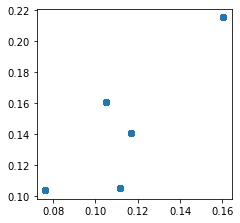

In [11]:
fig, ax = plt.subplots(figsize=(3.5, 3.5))

ax.scatter(atom_reps[:, 0], atom_reps[:, 1])

Repeat the process with layers with 0, 1 and 2 layers

In [12]:
atom_reps = {0: atom_reps}

In [13]:
for i in [1, 2]:
    # Make and fit the model
    model = make_model(2, i)
    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(train_loader, epochs=8, verbose=False)
    
    # Get the representations
    readout = model.get_layer('readout')
    rep_model = Model(inputs=model.inputs, outputs=readout.input)
    atom_reps[i] = rep_model.predict(valid_loader)

/home/lward/miniconda3/envs/molml/lib/python3.7/site-packages/tensorflow/python/framework/indexed_slices.py:432: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Plot the data

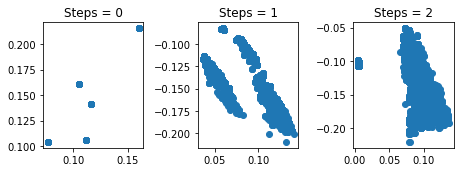

In [14]:
fig, axs = plt.subplots(1, 3, figsize=(6.5, 2.5))

for (key, reps), ax in zip(atom_reps.items(), axs):
    ax.scatter(reps[:, 0], reps[:, 1])
    ax.set_title(f'Steps = {key}')
    
fig.tight_layout()

*Answer*: The clusters of atoms with different elements. Without message passing, we do not differentiate atoms based on their local neighborhood. Once we start message passing, the atom features are "blurred" by their neighboring atoms. That leads to clusters which get bigger as we continue to add message passing layers

## Question 2: Train for real
First step is to add a dense layer and a scaling layer

In [15]:
def make_model(num_features: int, num_messages: int, readout_type: str = 'sum'):
    """Build an MPNN
    
    Args:
        num_features: Number of features to use to describe each atom and bond
        num_messages: Number of message passing steps
        readout_type: Function sued for the readout
    Returns:
        Keras models that generate molecule property
    """
    
    # The first step is to define which inputs to expand and their shapes/types
    node_graph_indices = layers.Input(shape=(1,), name='node_graph_indices', dtype='int32')
    atom_types = layers.Input(shape=(1,), name='atom', dtype='int32')
    bond_types = layers.Input(shape=(1,), name='bond', dtype='int32')
    connectivity = layers.Input(shape=(2,), name='connectivity', dtype='int32')

    # Squeeze the node graph and connectivity matrices
    #  Keras makes all input arrays 2D, I find it easier to deal with them as 1D vectors
    #  The squeeze operation removes the second dimension, and I use Kera's Lambda layer
    #  to quickly wrap a simple Tensorflow function
    squeeze = layers.Lambda(tf.squeeze, arguments={'axis': 1}, name='squeeze')
    snode_graph_indices = squeeze(node_graph_indices)
    satom_types = squeeze(atom_types)
    sbond_types = squeeze(bond_types)
    
    # Generate initial features for each atom and bond using embeddings
    atom_features = layers.Embedding(6, num_features, name='atom_embedding')(satom_types)
    bond_features = layers.Embedding(4, num_features, name='bond_embedding')(sbond_types)
    
    # Perform a few message passing steps
    message_layer = MessagePassingLayer(name='message_passing')
    for _ in range(num_messages):
        atom_features = message_layer(atom_features, bond_features, connectivity)
        
    # Reduce to a single set of features per molecule
    mol_features = Readout(readout_type, name='readout')(atom_features, snode_graph_indices)
    
    # Dense layer
    dense = layers.Dense(32, activation='relu', name='dense')(mol_features)
    
    # Create the output layer
    output = layers.Dense(1, activation='linear', name='output')(dense)
    
    # Scaling layer
    scale = Scaling(name='scaling')
    output = scale(output)
    
    # Create the models by defining which layers are the inputs and which are the outputs
    model = Model(inputs=[node_graph_indices, atom_types, bond_types, connectivity], outputs=output)
    return model

In [16]:
model = make_model(64, 2)

In [17]:
model.summary()

Model: "functional_13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
atom (InputLayer)               [(None, 1)]          0                                            
__________________________________________________________________________________________________
bond (InputLayer)               [(None, 1)]          0                                            
__________________________________________________________________________________________________
squeeze (Lambda)                (None,)              0           node_graph_indices[0][0]         
                                                                 atom[0][0]                       
                                                                 bond[0][0]                       
______________________________________________________________________________________

Set the value of scaling layer

In [18]:
_, outputs = next(iter(train_loader))

In [19]:
scale = model.get_layer('scaling')
scale.mean = outputs.numpy().mean()
scale.std = outputs.numpy().std()

Fit using early stopping

In [20]:
cbs = [callbacks.EarlyStopping(patience=8, restore_best_weights=True)]

In [21]:
model.compile('adam', loss='mean_squared_error')
model.fit(train_loader, epochs=128, verbose=True, validation_data=valid_loader, callbacks=cbs)

Epoch 1/128
633/633 [==============================] - 3s 5ms/step - loss: 0.0307 - val_loss: 0.0220
Epoch 2/128
633/633 [==============================] - 3s 4ms/step - loss: 0.0229 - val_loss: 0.0171
Epoch 3/128
633/633 [==============================] - 3s 5ms/step - loss: 0.0159 - val_loss: 0.0134
Epoch 4/128
633/633 [==============================] - 3s 5ms/step - loss: 0.0092 - val_loss: 0.0058
Epoch 5/128
633/633 [==============================] - 4s 6ms/step - loss: 0.0041 - val_loss: 0.0026
Epoch 6/128
633/633 [==============================] - 4s 6ms/step - loss: 0.0018 - val_loss: 0.0012
Epoch 7/128
633/633 [==============================] - 3s 5ms/step - loss: 0.0011 - val_loss: 0.0010
Epoch 8/128
633/633 [==============================] - 3s 5ms/step - loss: 0.0011 - val_loss: 9.0076e-04
Epoch 9/128
633/633 [==============================] - 3s 4ms/step - loss: 9.9137e-04 - val_loss: 8.7171e-04
Epoch 10/128
633/633 [==============================] - 4s 6ms/step - loss: 9.4

Evaluate on the test set

In [22]:
test_loss = model.evaluate(test_loader)

79/79 [==============================] - 0s 3ms/step - loss: 5.8394e-04


In [23]:
results = [{'messages': 2, 'loss': test_loss}]

Repeat for other network sizes

In [24]:
for n in tqdm([0, 1, 4, 8]):
    # Make the model
    model = make_model(64, n)
    
    # Set the scale later
    scale = model.get_layer('scaling')
    scale.mean = outputs.numpy().mean()
    scale.std = outputs.numpy().std()
    
    # Train the model
    model.compile('adam', loss='mean_squared_error')
    model.fit(train_loader, epochs=128, verbose=False, validation_data=valid_loader, callbacks=cbs)
    
    # Score the model
    results.append({
        'messages': n,
        'loss': model.evaluate(test_loader, verbose=False)
    })

100%|██████████| 4/4 [04:25<00:00, 66.29s/it]


Plot the dependence on number of message passing layers

Text(0, 0.5, 'Test loss')

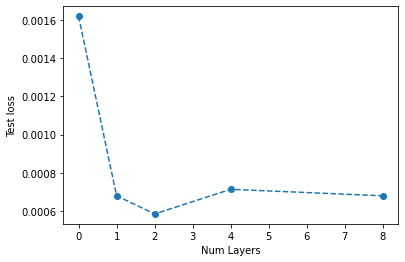

In [25]:
fig, ax = plt.subplots()

results = pd.DataFrame(results).sort_values('messages')

ax.plot(results['messages'], results['loss'], '--o')

ax.set_xlabel('Num Layers')
ax.set_ylabel('Test loss')

*Answer*: The accuracy improves until 4 layers. Our model is not able to benefit from complexity above that.

## Question 3: Explore readout layers
See how `u0` and `bandgap` require different readouts

In [26]:
results = []
for prop in tqdm(['u0_atom', 'bandgap']):
    # Make the data loaders
    train_loader = make_data_loader('../datasets/train_data.proto', batch_size=64, shuffle_buffer=8192, output_property=prop)
    valid_loader = make_data_loader('../datasets/valid_data.proto', batch_size=64, output_property=prop)
    test_loader = make_data_loader('../datasets/test_data.proto', batch_size=64, output_property=prop)
    
    # Get the true values
    y_true = np.concatenate([x[1] for x in test_loader])
    
    # Test different network designs
    for r in ['sum', 'max']:
        # Make the model
        model = make_model(64, 4, r)

        # Set the scale later
        _, outputs = next(iter(train_loader))
        scale = model.get_layer('scaling')
        scale.mean = outputs.numpy().mean()
        scale.std = outputs.numpy().std()

        # Train the model
        model.compile('adam', loss='mean_squared_error')
        model.fit(train_loader, epochs=128, verbose=False, validation_data=valid_loader, callbacks=cbs)

        # Score the model
        results.append({
            'property': prop,
            'readout': r,
            'y_true': y_true,
            'y_pred': model.predict(test_loader)[:, 0]
        })

  0%|          | 0/2 [00:00<?, ?it/s]/home/lward/miniconda3/envs/molml/lib/python3.7/site-packages/tensorflow/python/keras/engine/functional.py:543: UserWarning: Input dict contained keys ['n_atom', 'n_bond', 'bond_graph_indices'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])
/home/lward/miniconda3/envs/molml/lib/python3.7/site-packages/tensorflow/python/framework/indexed_slices.py:432: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
100%|██████████| 2/2 [08:29<00:00, 254.94s/it]


In [27]:
results = pd.DataFrame(results)

Plot the predicted versus actual

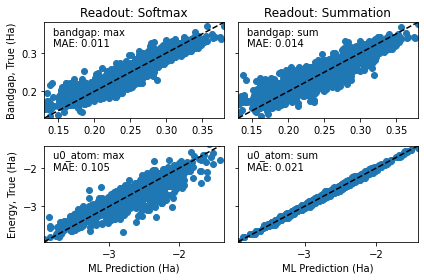

In [28]:
fig, axxs = plt.subplots(2, 2, sharey='row')

for (prop, group), axs in zip(results.groupby('property'), axxs):
    for (readout, record), ax in zip(group.groupby('readout'), axs):
        record = record.iloc[0]
        ax.scatter(record['y_true'], record['y_pred'])
        mae=np.abs(record['y_true'] - record['y_pred']).mean()
        
        # Make it pretty
        ax.text(0.05, 0.75, f'{prop}: {readout}\nMAE: {mae:.3f}', transform=ax.transAxes)
        ax.set_xlim([np.concatenate(record[['y_true', 'y_pred']]).min(),
                     np.concatenate(record[['y_true', 'y_pred']]).max()])
        ax.set_ylim(ax.get_xlim())
        
        ax.plot(ax.get_xlim(), ax.get_xlim(), 'k--')
        

# Add some labels
axxs[0, 0].set_title('Readout: Softmax')
axxs[0, 1].set_title('Readout: Summation')

axxs[0, 0].set_ylabel('Bandgap, True (Ha)')
axxs[1, 0].set_ylabel('Energy, True (Ha)')

for ax in axxs[1, :]:
    ax.set_xlabel('ML Prediction (Ha)')
   
fig.tight_layout()

In [29]:
results['mae'] = results.apply(lambda x: np.abs(x['y_pred'] - x['y_true']).mean(), axis=1)

In [30]:
results

,property,readout,y_true,y_pred,mae
0,u0_atom,sum,"[-2.964215, -2.91219, -2.276578, -2.414455, -2...","[-2.9121647, -2.9080532, -2.2949958, -2.413934...",0.021371
1,u0_atom,max,"[-2.964215, -2.91219, -2.276578, -2.414455, -2...","[-2.9225144, -3.3470438, -2.4179542, -2.280081...",0.105063
2,bandgap,sum,"[0.3134, 0.3242, 0.2296, 0.2251, 0.2216, 0.176...","[0.30633554, 0.31457192, 0.20872626, 0.2518227...",0.014267
3,bandgap,max,"[0.3134, 0.3242, 0.2296, 0.2251, 0.2216, 0.176...","[0.30489665, 0.32449967, 0.23743603, 0.2178953...",0.011369


*Answer*:
- Softmax works by finding
- Softmax performs better for bandgap prediction, but worse for the atomization energy.. What it does is find the atom that has the largest feature output the 